**1. Installing the requirements**

In [ ]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install mxnet-cu101

     |████████████████████████████████| 46.9MB 68kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6MB 80kB/s 
     |████████████████████████████████| 5.1MB 19.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 1.1MB 4.5MB/s 
     |████████████████████████████████| 122kB 13.0MB/s 
     |████████████████████████████████| 14.1MB 249kB/s 
     |████████████████████████████████| 317kB 59.0MB/s 
     |█████████████

     |████████████████████████████████| 356.7MB 50kB/s 


**2. Changing the working directory**

In [ ]:
# Don't forget to mount the google drive
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


**3. Importing the requirements**

In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

**4. Setting and loading the data**

In [ ]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.875, 0.75, 0.66], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('DataSet/train/'),
                               setting=os.path.expanduser('DataSet/train/train.txt'),
                               slowfast=True,
                               train=True,
                               new_length=64,
                               slow_temporal_stride=16,
                               fast_temporal_stride=2,
                               video_loader=True,
                               use_decord=True,
                               transform=transform_train)

print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 294 training samples.


**5. Loading the model**

In [ ]:
net = get_model(name = 'slowfast_4x16_resnet50_custom', nclass = 6)
net.collect_params().reset_ctx(ctx)
print(net)

100%|██████████| 134964/134964 [00:04<00:00, 30846.86KB/s]


SlowFast(
  (fast_conv1): Conv3D(3 -> 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
  (fast_relu): Activation(relu)
  (fast_maxpool): MaxPool3D(size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (fast_res2): HybridSequential(
    (0): Bottleneck(
      (conv1): Conv3D(8 -> 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv2): Conv3D(8 -> 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv3): Conv3D(8 -> 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm(axis=1,

**6. Setting up the hyperparameters**

In [ ]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

**7. Trainning**

[Epoch 0] train=0.292517 loss=1.674142 time: 310.206685
[Epoch 1] train=0.581633 loss=1.151713 time: 208.158032
[Epoch 2] train=0.707483 loss=0.774064 time: 205.599636
[Epoch 3] train=0.829932 loss=0.518897 time: 206.539372
[Epoch 4] train=0.850340 loss=0.420811 time: 208.538515
[Epoch 5] train=0.867347 loss=0.389243 time: 204.670315
[Epoch 6] train=0.914966 loss=0.285852 time: 205.054644
[Epoch 7] train=0.908163 loss=0.267842 time: 203.779069
[Epoch 8] train=0.945578 loss=0.224573 time: 205.230999
[Epoch 9] train=0.945578 loss=0.168930 time: 207.979764
[Epoch 10] train=0.979592 loss=0.126800 time: 206.988502
[Epoch 11] train=0.942177 loss=0.169094 time: 206.063117


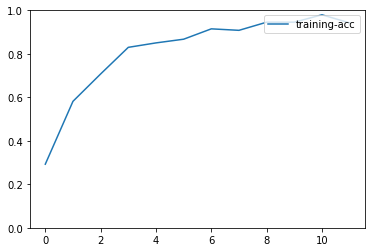

In [ ]:
epochs = 12
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

**8. Saving the model**

In [ ]:
net.save_parameters('Model/signof5_slowfast_4x16.params')

**9. Running my infrence**

In [ ]:
# Map
CLASS_MAP = {
    0: "Opaque",
    1: "Red",
    2: "Green",
    3: "Yellow",
    4: "Bright",
    5: "Light-blue"
}

In [ ]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

video_fname = 'DataSet/test/001_001_001.mp4'
vr = decord.VideoReader(video_fname)
fast_frame_id_list = range(0, 64, 2)
slow_frame_id_list = range(0, 64, 16)
frame_id_list = list(fast_frame_id_list) + list(slow_frame_id_list)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (36, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is readed and preprocessed.')

Video data is readed and preprocessed.


In [ ]:
# Running the prediction
pred = net(nd.array(clip_input,  ctx = mx.gpu(0)))
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (CLASS_MAP[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[Green], with probability 0.224.
	[Bright], with probability 0.208.
	[Yellow], with probability 0.179.
	[Opaque], with probability 0.175.
	[Light-blue], with probability 0.112.
